### Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# a)

### Read data

In [2]:
employment = pd.read_excel("dataset/employment_08_09.xlsx")
print(employment.shape)

(5412, 21)


In [3]:
employment.head()

,age,race,earnwke,employed,unemployed,married,union,ne_states,so_states,ce_states,...,government,private,self,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female
0,53,1,NaN,1,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
1,39,1,NaN,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,1
2,41,1,500.0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,27,1,520.0,1,0,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
4,29,3,615.0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0


### Variable overview

discrete
- binary
    - employed
    - unemployed
    - marred
    - union
    - ne_states
    - so_states
    - ce_states
    - we_states
    - private
    - government
    - self
    - educ_lths
    - educ_hs
    - educ_somecol
    - educ_adv
- integer
    - age
    - race

continuous
- earnwke

### Sanity check target variables

In theory variables `employed` and `unemployed` should be the same and containing reduntant information.

In [4]:
fig = px.histogram(employment, x="employed", color="unemployed", barmode="group")
fig.show()

One can see, that there are 435 data points which contain no information about wether or not the person was employed in 2009.

These points will be removed from the data.

In [5]:
unknown_employment_status = (employment["employed"] == employment["unemployed"])
unknown_employment_status[unknown_employment_status == True]

employment = employment[~unknown_employment_status]
employment.drop(columns="unemployed", inplace=True)
employment.head()

,age,race,earnwke,employed,married,union,ne_states,so_states,ce_states,we_states,government,private,self,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female
0,53,1,NaN,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
1,39,1,NaN,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
2,41,1,500.0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3,27,1,520.0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
4,29,3,615.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


In [6]:
target_group = employment["employed"].value_counts()
print("Amount of employment vs. unemployment in data: {n_employed} vs. {n_unemployed}".format(n_employed=target_group[1], n_unemployed=target_group[0]))

Amount of employment vs. unemployment in data: 4738 vs. 239


### Check if missing values exist per feature

In [7]:
employment.isna().any(axis=0)

age             False
race            False
earnwke          True
employed        False
married         False
union           False
ne_states       False
so_states       False
ce_states       False
we_states       False
government      False
private         False
self            False
educ_lths       False
educ_hs         False
educ_somecol    False
educ_aa         False
educ_bac        False
educ_adv        False
female          False
dtype: bool

### Remove rows that contain missing values

In [8]:
employment.dropna(inplace=True)
employment.head()

,age,race,earnwke,employed,married,union,ne_states,so_states,ce_states,we_states,government,private,self,educ_lths,educ_hs,educ_somecol,educ_aa,educ_bac,educ_adv,female
2,41,1,500.00,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3,27,1,520.00,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
4,29,3,615.00,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
5,50,3,865.38,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1
6,27,1,712.50,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0


### Check for variables that do not contain any information (no information means in this case: value does not vary)

In [9]:
irrelevant_vars = set()
for col in employment:
    if col in ["age", "race", "earnwke", "employed"]:
        continue
    n_values = employment[col].value_counts()
    if len(n_values) == 1:
        print("variable '{var}' does not contain any information.".format(var=col))
        irrelevant_vars.add(col)

variable 'self' does not contain any information.


In [10]:
employment.drop(columns=[col for col in list(irrelevant_vars)], inplace=True)

### Define input and target variables

In [11]:
X = employment.drop(columns="employed")
y = employment["employed"]

### Get train/test split

In [12]:
input_train, input_test, label_train, label_test = train_test_split(X, y, train_size=0.8, shuffle=True, stratify=y)

## Possible model classes

The target variable is discrete (more specifically binary) and that's why we are doing classification.

Possible classification algorithms are:
- k-Nearest-Neighbour
- Logistic Regression
- Support Vector Machine
- Decision Tree
- Neural Network

## Linear Regression

In [13]:
model = linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

accuracy:  0.9478458049886621


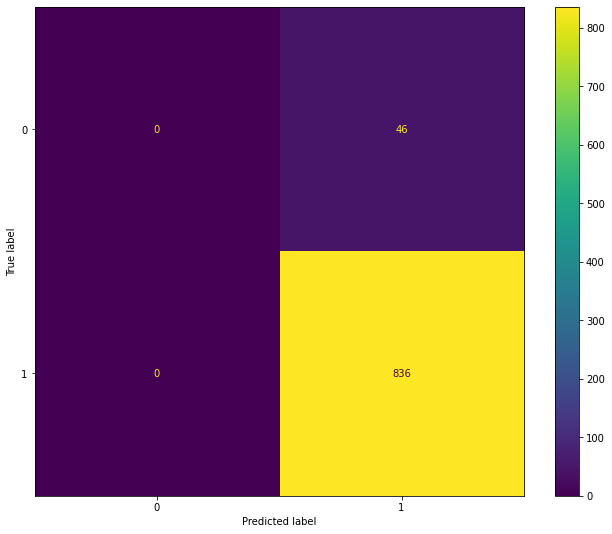

In [14]:
plt.rcParams["figure.figsize"] = (11, 9)

y_hat = model.predict(input_test)

print("accuracy: ", accuracy_score(label_test, y_hat.round()))

cm = confusion_matrix(label_test, y_hat.round())
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()